In [23]:
from tensorflow.keras.layers import Input, Embedding, Subtract, Concatenate, Flatten, Multiply, Dense
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Multiple-Input Models
We'll build a model which takes in three layers.

In [3]:
season_data = pd.read_csv('./data/games_season.csv')
print(season_data.head())

X_train, X_test, y_train, y_test = train_test_split(season_data[['team_1', 'team_2', 'home']], 
                                                    season_data['score_diff'], 
                                                    test_size=.3)

n_teams = pd.unique(season_data['team_1']).shape[0]
print(n_teams)

   season  team_1  team_2  home  score_diff  score_1  score_2  won
0    1985    3745    6664     0          17       81       64    1
1    1985     126    7493     1           7       77       70    1
2    1985     288    3593     1           7       63       56    1
3    1985    1846    9881     1          16       70       54    1
4    1985    2675   10298     1          12       86       74    1
10888


In [4]:
input_tensor = Input(shape=(1, ))

teams_ratings = Embedding(
    input_dim=n_teams,
    output_dim=1,
    input_length=1,
    name='Team-Strength-Lookup'
)

embed_tensor = teams_ratings(input_tensor)
flatten_tensor = Flatten()(embed_tensor)
model = Model(input_tensor, flatten_tensor)


input_1 = Input(shape=(1, ))
input_2 = Input(shape=(1, ))
input_3 = Input(shape=(1, ))

output_tensor_1 = model(input_1)
output_tensor_2 = model(input_2)

concat_layer = Concatenate()([output_tensor_1, output_tensor_2, input_3])

out_layer = Dense(1)(concat_layer)

regular_season_model = Model([input_1, input_2, input_3], out_layer)

regular_season_model.compile(optimizer='adam', loss='mean_absolute_error')

In [5]:
epochs = 10

history = regular_season_model.fit([X_train['team_1'], X_train['team_2'], 
                                    X_train['home']], 
                          y_train, 
                          batch_size=2048,
                          epochs=epochs, 
                          validation_split=.1)

Epoch 1/10
97/97 [==============================] - 1s 5ms/step - loss: 12.1384 - val_loss: 12.1946
Epoch 2/10
97/97 [==============================] - 0s 3ms/step - loss: 12.1063 - val_loss: 12.1634
Epoch 3/10
97/97 [==============================] - 0s 3ms/step - loss: 12.0673 - val_loss: 12.1260
Epoch 4/10
97/97 [==============================] - 0s 3ms/step - loss: 12.0210 - val_loss: 12.0825
Epoch 5/10
97/97 [==============================] - 0s 3ms/step - loss: 11.9678 - val_loss: 12.0330
Epoch 6/10
97/97 [==============================] - 0s 3ms/step - loss: 11.9074 - val_loss: 11.9773
Epoch 7/10
97/97 [==============================] - 0s 3ms/step - loss: 11.8402 - val_loss: 11.9163
Epoch 8/10
97/97 [==============================] - 0s 3ms/step - loss: 11.7664 - val_loss: 11.8501
Epoch 9/10
97/97 [==============================] - 0s 3ms/step - loss: 11.6872 - val_loss: 11.7794
Epoch 10/10
97/97 [==============================] - 0s 3ms/step - loss: 11.6031 - val_loss: 11.7050

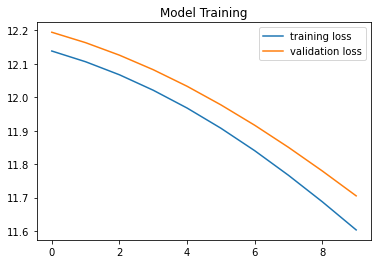

In [6]:
plt.plot(np.arange(epochs), history.history['loss'], label='training loss')
plt.plot(np.arange(epochs), history.history['val_loss'], label='validation loss')

plt.legend()
_ = plt.title('Model Training')

In [7]:
# We could have evaluated this on the /data/games_season.csv data
results = regular_season_model.evaluate([X_test['team_1'], X_test['team_2'], 
                                         X_test['home']], y_test,
                               batch_size=128)

732/732 [==============================] - 1s 2ms/step - loss: 11.6399


In [8]:
tourney_data = pd.read_csv('./data/games_tourney.csv')

regular_season_model.evaluate([tourney_data['team_1'], tourney_data['team_2'],
                               tourney_data['home']],
                     tourney_data['score_diff'], batch_size=128)

34/34 [==============================] - 0s 1ms/step - loss: 11.5261


11.526078224182129

Note that the embedding layer adds a lot of parameters (mapping integers -> floats)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 Team-Strength-Lookup (Embed  (None, 1, 1)             10888     
 ding)                                                           
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


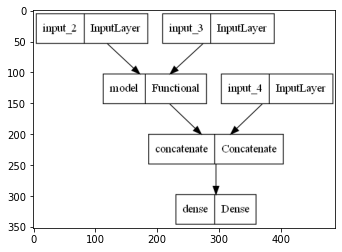

In [10]:
plot_model(regular_season_model, to_file='./data/model.png')

data = plt.imread('./data/model.png')
plt.imshow(data)

In [11]:
input_1 = Input(shape=(1, ))
input_2 = Input(shape=(1, ))

multiply_layer = Multiply()([input_1, input_2])

mock_model = Model([input_1, input_2], multiply_layer)

X = np.random.normal(size=(1000, 2))
y = X[:, 0] * X[:, 1]

mock_model.compile(optimizer='sgd', loss='mean_absolute_error')

mock_model.fit([X[:, 0], X[:, 1]], y)

32/32 [==============================] - 0s 1ms/step - loss: 2.1626e-08


In [12]:
mock_model.predict([np.array([[5]]), np.array([[4]])])

1/1 [==============================] - 0s 82ms/step


array([[20.]], dtype=float32)

### Stacking Models

Stacking models is a technique of building a model which as an input takes in predictions from different model. The datasets on which they are trained should be disjoint. 

In [13]:
input_tensor = Input(shape=(3,))

output_tensor = Dense(1)(input_tensor)

tourney_model = Model(input_tensor, output_tensor)

tourney_data['pred'] = regular_season_model.predict([tourney_data['team_1'], 
                                                     tourney_data['team_2'], 
                                                     tourney_data['home']])

tourney_model.compile(optimizer='adam', loss='mean_absolute_error')

epochs = 10

tourney_model.fit(tourney_data[['seed_diff', 'home', 'pred']], 
                 tourney_data['score_diff'], 
                 batch_size=256, 
                 validation_split=.1,
                 epochs=epochs)

133/133 [==============================] - 0s 1ms/step
Epoch 1/10
15/15 [==============================] - 1s 12ms/step - loss: 11.6100 - val_loss: 11.3720
Epoch 2/10
15/15 [==============================] - 0s 3ms/step - loss: 11.5514 - val_loss: 11.3136
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 11.4931 - val_loss: 11.2546
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 11.4340 - val_loss: 11.1963
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 11.3764 - val_loss: 11.1380
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 11.3199 - val_loss: 11.0794
Epoch 7/10
15/15 [==============================] - 0s 4ms/step - loss: 11.2635 - val_loss: 11.0210
Epoch 8/10
15/15 [==============================] - 0s 5ms/step - loss: 11.2070 - val_loss: 10.9638
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 11.1526 - val_loss: 10.9063
Epoch 10/10
15/15 [=========================

### Multi Output Models

We'll build a model which performs classification and regression at the same time. 

In [24]:
input_tensor = Input(shape=(2,))

output_tensor_reg = Dense(1, activation='linear', use_bias=False)(input_tensor)
output_tensor_prob = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_reg)

multi_out_model = Model(input_tensor, [output_tensor_reg, output_tensor_prob])

multi_out_model.compile(loss=['mae', 'binary_crossentropy'], optimizer=Adam(learning_rate=0.01))

In [26]:
epochs = 10

history = multi_out_model.fit(tourney_data[['seed_diff', 'pred']], [tourney_data['score_diff'], tourney_data['won']],
                    batch_size=128, 
                    epochs=epochs,
                    validation_split=.1)

Epoch 1/10
30/30 [==============================] - 0s 5ms/step - loss: 10.0283 - dense_12_loss: 9.4727 - dense_13_loss: 0.5556 - val_loss: 9.4663 - val_dense_12_loss: 8.9174 - val_dense_13_loss: 0.5490
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 9.9046 - dense_12_loss: 9.3479 - dense_13_loss: 0.5568 - val_loss: 9.3430 - val_dense_12_loss: 8.7942 - val_dense_13_loss: 0.5489
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 9.8267 - dense_12_loss: 9.2707 - dense_13_loss: 0.5559 - val_loss: 9.2675 - val_dense_12_loss: 8.7193 - val_dense_13_loss: 0.5481
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 9.7730 - dense_12_loss: 9.2183 - dense_13_loss: 0.5547 - val_loss: 9.2326 - val_dense_12_loss: 8.6847 - val_dense_13_loss: 0.5479
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 9.7426 - dense_12_loss: 9.1884 - dense_13_loss: 0.5542 - val_loss: 9.2102 - val_dense_12_loss: 8.6623 - val_dense_13_lo

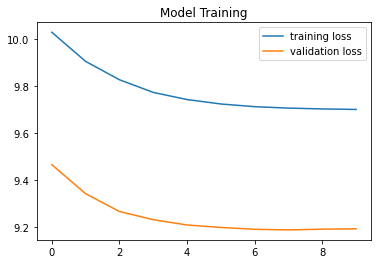

In [27]:
plt.plot(np.arange(epochs), history.history['loss'], label='training loss')
plt.plot(np.arange(epochs), history.history['val_loss'], label='validation loss')

plt.legend()
_ = plt.title('Model Training')

In [28]:
tourney_data.mean()

season        2001.193198
team_1        5589.146906
team_2        5589.146906
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.131318
score_2         71.131318
won              0.500000
pred            -0.006498
dtype: float64

In [30]:
multi_out_model.get_weights()

[array([[1.1079432],
        [2.2111952]], dtype=float32),
 array([[0.13754821]], dtype=float32)]

In [36]:
prediction = multi_out_model.predict(np.array([[1, 1]]))
prediction

1/1 [==============================] - 0s 26ms/step


[array([[3.3191385]], dtype=float32), array([[0.6121934]], dtype=float32)]

What happened is that the layer with probability part took the regression output and predicted the probability of winning a game for the team 1 given the score

In [38]:
from scipy.special import expit as sigmoid

sigmoid(multi_out_model.get_weights()[1][0] * prediction[0][0])

array([0.6121934], dtype=float32)